# Learning Agency Lab - Automated Essay Scoring 2.0

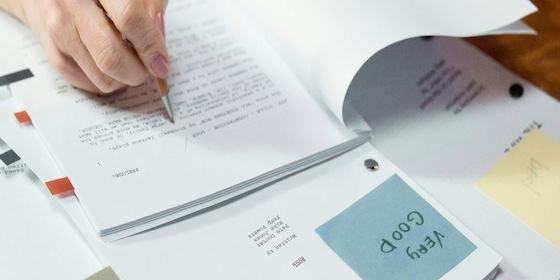

## 1. 대회 설명

- 학생이 작성한 에세이를 채점하는 자동화 모델 개발

## 2. 데이터

= 약 24,000개의 학생 작성 논증형 에세이로 구성되어 있으며, 각 에세이는 1~6점 척도로 평가됨 <br>
- **`train.csv`**: 
    - `essay_id`: 에세이 고유 ID
    - `full_text`: 에세이 전체 텍스트
    - `score`: 에세이의 총괄 점수 (1~6점) 
- **`test.csv`**:
    - `essay_id`: 에세이 고유 ID
    - `full_text`: 에세이 전체 텍스트
    - `score`: 없음 (예측 대상)
- **`sample_submission.csv`**:
    - `essay_id`: 에세이 고유 ID
    - `score`: 예측된 총괄 점수 (1~6점)

## 3. 성능 평가 방식 이해

- **Quadratic Weighted Kappa(QWK)**
    - QWK는 두 결과 간의 일치도를 측정하며, 값은 0(우연 일치)에서 1(완전 일치) 사이로 나타남
    - 예외적으로 우연 일치보다 낮은 수준의 일치가 있을 경우, 값이 0보다 작아질 수 있음
    - QWK는 다음과 같이 계산됨:

        1. 히스토그램 행렬 O: 실제 값과 예측 값의 빈도를 기록한 𝑁 × 𝑁 행렬. 𝑂𝑖,𝑗는 실제 값 𝑖가 예측 값 𝑗를 받은 에세이 개수를 나타냄.
        2. 가중치 행렬 w: 실제 값과 예측 값 간의 차이에 기반해 계산됩니다.
        3. 기대값 행렬 𝐸: 실제 값과 예측 값이 상관관계가 없다고 가정했을 때의 결과를 기록한 𝑁×𝑁 행렬. 𝐸는 실제 값과 예측 값의 히스토그램 벡터의 외적을 기반으로 계산되며, 𝑂와 동일한 합계를 가지도록 정규화됩니다.
        

## 4. 모델링
- 5 Fold Deberta
- 15 Fold LGBM

## ► 5 Fold Deberta

### **📍 Deberta(DeBERTa) 모델 설명**

= BERT모델의 변형 중 하나로, Microsoft에서 개발한 트랜스포머 기반의 자연어 처리 모델 <br>
= BERT의 한계를 개선하기 위해 몇 가지 혁신적인 기법을 도입하여 성능을 향상시킴

- **DeBERTa의 특징**
    1. Disentangled Attention Mechanism (분리된 주의 메커니즘):
        - BERT와 같은 기존 트랜스포머 모델은 단어와 위치 임베딩을 합성하여 하나의 임베딩을 생성하고, 이 정보를 통해 주의(attention)를 계산함
        - 그러나 DeBERTa는 단어 임베딩과 위치 임베딩을 별도로 처리하여, 각각의 특성을 분리하여 처리함
        - 이 방식은 단어의 의미와 단어의 위치를 보다 잘 반영할 수 있게 해줌
        - 이를 통해 모델은 더 정교한 문맥 정보를 처리할 수 있고, 성능이 향상됨
    <br>
    2. Enhanced Mask Decoder (강화된 마스크 디코더):
        - BERT는 마스크된 언어 모델(Masked Language Model, MLM) 방식을 사용해 일부 단어를 마스킹하고 예측
        - DeBERTa는 이 방식을 향상시킨 마스크 디코더를 사용하여, 더 많은 문맥 정보를 학습할 수 있게함
        - 이를 통해 DeBERTa는 더 강력한 예측 능력을 가지며, 성능을 개선할 수 있음
    <br>
    3. Positional Encoding (위치 인코딩):
        - DeBERTa는 위치 인코딩을 기존의 방법과 다르게 적용하여, 입력 토큰의 상대적인 위치를 좀 더 효과적으로 처리할 수 있음
        - 이를 통해 모델이 더 세밀한 문맥 정보를 이해하고 예측할 수 있습니다.


* keybert - 순서, 명사 추출 good

### 📍 **Settings**

In [2]:
# 라이브러리 임포트
import pandas as pd
import gc
import pickle
import torch

# 테스트 데이터 로드
from google.colab import files
import pandas as pd
_test = pd.read_csv('/content/drive/MyDrive/Zerobase/Kaggle/Data/learning-agency-lab-automated-essay-scoring-2/test.csv')

# 런타임 절약 조건 설정
ENABLE_DONT_WASTE_YOUR_RUN_TIME = len(_test) < 10 # 테스트 데이터의 길이가 10개 미만일 경우 True로 설정
if ENABLE_DONT_WASTE_YOUR_RUN_TIME: # 위 조건에 만족하는 경우
    del _test # 테스트 데이터 삭제
    gc.collect() # 메모리 해제 

# CUDA(GPU) 사용 여부 확인
import torch
CUDA_AVAILABLE = torch.cuda.is_available()
print(f"{CUDA_AVAILABLE = }")

CUDA_AVAILABLE = False


In [ ]:
# 라이브러리 임포트
import xgboost as xgb
import pandas as pd
# Hugging Face 라이브러리 임포트 
from transformers import (
    AutoTokenizer, # 각 모델에 맞는 토크나이저를 자동으로 로딩해주는 클래스
    AutoModelForSequenceClassification, # 시퀀스 분류 작업을 위한 모델을 자동으로 로딩해주는 클래스 (여기선 Deberta)
    Trainer, # 모델 훈련 및 평가를 쉽게 할 수 있도록 도와주는 API
    TrainingArguments, # 훈련에 필요한 하이퍼파라미터 설정하는데 사용되는 클래스 
    DataCollatorWithPadding # 패딩을 자동으로 적용해주는 클래스
)
# Pandas 데이터프레임을 NLP 모델에 적합한 Dataset 형식으로 변환해주는 라이브러리
from datasets import Dataset
# 파일 경로에서 패턴 매칭해서 파일 목록 가져오는 라이브러리
from glob import glob  
# 메모리 관련 라이브러리
import gc
# PyTorch 라이브러리
import torch
# 모델 출력 값(logit)을 확률로 변환해주는 라이브러리
from scipy.special import softmax

## softmax 함수 나중에 보기!!! 

# 변수 정의 
MAX_LENGTH = 1024 # 입력 텍스트의 최대 길이를 1024 토큰으로 제한 
TEST_DATA_PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv" # 테스트 데이터 경로
MODEL_PATH = '/kaggle/input/aes2-400-20240419134941/*/*' # 대회 baseline 모델 경로
EVAL_BATCH_SIZE = 1 # 평가 시, 한번에 처리할 배치 크기를 1로 설정

### 📍 Deberta Model

In [ ]:
# 모델 로드
models = glob(MODEL_PATH) # glob 함수 사용해서 위 MODEL_PATH 통해서 가져옴

# 토크나이저 로드
# AutoTokenizer.from_pretrained = 주어진 경로에서 모델 설정 파일(config.json 등)을 찾고 해당 모델에 최적화된 토크나이저를 자동으로 생성
tokenizer = AutoTokenizer.from_pretrained(models[0]) # 첫 번째 파일/폴더 경로에 있는 모델 사용 (아마 Deberta 모델 일듯)

# 토큰화 함수 정의
def tokenize(sample):
    # tokenizer = Hugging Face 토크나이저
    # sample['full_text'] = 데이터 컬럼 'full_text'를 토큰화함
    # max_length=MAX_LENGTH = 위에서 정의한 대로 텍스트 길이가 1,024개가 넘어가면 자르기
    # truncation=TRUE = 토큰 길이가 MAX_LENGTH를 초과할 경우 초과 부분 자르기 True 설정
    return tokenizer(sample['full_text'], max_length=MAX_LENGTH, truncation=True)

# 테스트 데이터 로드
df_test = pd.read_csv(TEST_DATA_PATH)

# DataFrame -> Dataset 객체로 변환
# Dataset.map(tokenize) = Dataset의 모든 샘플에 대해 tokenize 함수 적용 
# tokenize 결과로 input_ids, attention_mask 등의 정보(컬럼)를 새로 생성하며 
# 기존의 원본 텍스트인 'essay_id', 'full_text' 컬럼 삭제
ds = Dataset.from_pandas(df_test).map(tokenize).remove_columns(['essay_id', 'full_text'])

# 학습/평가 파라미터 설정 
# TrainingArgumets() = Hugging Face에서 모델 학습/평가 시 필요한 환경 설정을 정의하는 객체
# 아래 args 객체는 이후 평가 과정에서 'Trainer'에 전달되어 사용될 예정
args = TrainingArguments(
    ".", # 출력 파일이 저장될 경로 지정 ("." - 현재 경로에 저장)
    per_device_eval_batch_size=EVAL_BATCH_SIZE, # 평가 시 배치 크기 설정 (위에서 정의한 EVAL_BATCH_SIZE=1 로 설정)
    report_to="none" # 평가 진행 상황을 로깅할 플랫폼을 설정하는데, 여기선 로그를 기록하지 않음 
)

# 예측 및 결과 수행 
predictions = [] # 예측 결과를 저장할 빈 리스트 생성
for model in models:
    # 모델 로드 (Hugging Face의 AutoModelForSequenceClassification 라이브러리 사용)
    model = AutoModelForSequenceClassification.from_pretrained(model) 
    # Trainer 객체 생성 및 파라미터 설정
    trainer = Trainer(
        model=model, # 모델
        args=args,   # 파라미터
        data_collator=DataCollatorWithPadding(tokenizer), # 패딩 작업
        tokenizer=tokenizer # 토크나이저
    )
    # 예측 결과를 softmax를 통해 확률로 변환
    preds = trainer.predict(ds).predictions # 예측 결과
    predictions.append(softmax(preds, axis=-1)) # 예측 결과를 확률로 변환하여 리스트에 저장
    del  model, trainer # 메모리 해제를 위해 모델과 트레이너 객체 삭제
    torch.cuda.empty_cache() # GPU 메모리 비우기
    gc.collect() # 메모리 해제 

predicted_score = 0.

for p in predictions:
    predicted_score += p

predicted_score /= len(predictions)

In [ ]:
df_test['score'] = predicted_score.argmax(-1) + 1
df_test.head()

## ► 15 Fold LGBM

### 📍 Libraries

In [ ]:
# 라이브러리 임포트
import gc
import lightgbm as lgb
from sklearn.ensemble import VotingRegressor
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import spacy
import string
import random
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier,BaggingClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import cohen_kappa_score
from lightgbm import log_evaluation, early_stopping
from sklearn.linear_model import SGDClassifier
import polars as pl
import joblib

In [ ]:
##### Polars 라이브러리 (pl)
##### pandas와 비슷하나 더 빠른 속도로 처리함. 멀티코어 처리와 메모리 효율성 덕분에 사용한 듯


# 에세이의 각 문단 분리하기 
columns = [
    (
        pl.col("full_text").str.split(by="\n\n").alias("paragraph") 
    ),  # 'full_text' 컬럼을 \n\n(빈 줄)기준으로 나누어 각 문단을 "paragraph" 라는 컬럼으로 변환
]


# 데이터 경로
PATH = "/content/drive/MyDrive/Zerobase/Kaggle/Data/learning-agency-lab-automated-essay-scoring-2/"



# 데이터 로드
# 위에서 정의한 columns 사용하여 'full_text' 컬럼을 'paragraph' 컬럼으로 변환
train = pl.read_csv(PATH + "train.csv").with_columns(columns)
test = pl.read_csv(PATH + "test.csv").with_columns(columns)



##### spaCy 라이브러리 (spacy)
##### NLP 라이브러리 (영어 텍스트에 대해 전처리 및 분석 도구 로 유명. NLTK 와 Spacy 가 대표적)


#
nlp = spacy.load("en_core_web_sm") # en_core_web_sm 모델 로드 
with open ('/content/drive/MyDrive/Zerobase/Kaggle/Data/learning-agency-lab-automated-essay-scoring-2/words.txt', 'r') as file:
    # 파일 내의 각 단어를 소문자로 변환, 양쪽 공백을 제거한 후, set 자료형으로 저장 
    english_vocab = set(word.strip().lower() for word in file)



# 확인 (출력)
train.head(1)

In [ ]:
# train['full_text']
print('원본(full_text) 형식: ')
print(train['full_text'][1])

print('---------------------')

# train['paragraph']
print('문단 나눈(paragraph) 형식: ')
print(train['paragraph'][1])

### 📍 Features Engineering

#### ► 텍스트 전처리

In [ ]:
# 스펠링 오류 검사
def count_spelling_errors(text):
  # 객체 생성
  # nlp = spaCy의 자연어 처리 pipeline 객체 
  doc = nlp(text)
  # 표제어 및 소문자 변환하여 리스트에 저장 
  # token.lemma_ = 표제어(lemma) 반환 (예: "running" -> "run") 
  # token.lower() = 소문자 변환 
  lemmatized_tokens = [token.lemma_.lower() for token in doc]
  # 표제어 및 소문자 변환한 리스트에서 각 토큰이 enlish_vocab(영어 단어 목록)안에 존재하는지 확인 
  spelling_errors = sum(1 for token in lemmatized_tokens if token not in english_vocab)
  # 스펠링 오류의 개수 반환 
  return spelling_errors


# HTML 태그 제거
def removeHTML(x):
  html = re.compile(r'<.*?>') # HTML 태그 (<,>) 찾기
  return html.sub(r'',x) # 빈 문자열로 대체 


# 문자열 전처리!
def dataPreprocessing(x):
  # 소문자 변환
  x = x.lower()
  # HTML 태그 제거
  x = removeHTML(x)
  # '@'로 시작하는 문자열 제거
  x = re.sub(r'@\w+', '', x)
  # 숫자 제거
  x = re.sub("'\d+", '', x) # (작은따옴표(') 뒤에 오는 숫자가 있나봄 (예: '1234))
  x = re.sub("\d+", '', x)  # 일반적인 숫자 제거 
  # URL 제거
  x = re.sub("http\w+", '', x)
  # 반복되는 공백 하나의 공백으로 변경
  x = re.sub(r"\s+", " ", x)
  # 반복되는 ,. 하나의 ,.로 변경
  x = re.sub(r"\.+", ".", x)
  x = re.sub(r"\,+", ",", x)
  # 문장의 시작과 끝에서 공백 제거
  x = x.strip()
  return x

#### ► Paragraph 전처리

In [ ]:
# punctuation 제거 (예: '.', ',', '?', ':' 등)
def remove_punctuation(text):
  # string.punctuation 모듈 = 문자열의 모든 punctuation 포함하고 있음
  # str.maketrans(바꾸려는 문자, 대체할 문자, 삭제할 문자)
  # str.maketrans('', '', string.punctuation) = 바꾸려는 문자 없음, 대체할 문자 없음, punctuation 은 삭제
  translator = str.maketrans('', '', string.punctuation)
  return text.translate(translator)


# 문단 전처리 
def Paragraph_Preprocess(tmp):
  # 'paragraph' 컬럼 행 단위로 나누기
  tmp = tmp.explode('paragraph')
  # 위에서 정의했던 문자열 전처리 적용 (소문자 변환, html 태그 제거 등)
  tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
  # 위에서 정의했던 punctuation 제거 적용 + 새로운 컬럼에 저장
  tmp = tmp.with_columns(pl.col('paragraph').map_elements(remove_punctuation).alias('paragraph_no_punctuation'))
  # 위에서 정의했던 스펠링 오류 검사 적용 + 새로운 컬럼에 저장
  tmp = tmp.with_columns(pl.col('paragraph_no_punctuation').map_elements(count_spelling_errors).alias('paragraph_error_num'))
  # 문단의 길이 (글자 수) 계산하고 + 새로운 컬럼에 저장
  tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x)).alias('paragraph_len'))
  # 문장 수 계산 (각 문단을 마침표('.')로 나누어 문장 수 계산)
  # 단어 수 계산 (각 문단을 공백()으로 나누어 단어 수 계산)
  tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x.split('.'))).alias('paragraph_sentence_cnt'),
                        pl.col('paragraph').map_elements(lambda x: len(x.split(' '))).alias('paragraph_word_cnt'),)
  return tmp

                         

# 통계적 특성 계산

# 문단 길이, 문장 수, 단어 수 변수에 저장
paragraph_fea = ['paragraph_len', 'paragraph_sentence_cnt', 'paragraph_word_cnt']
# 스펠링 오류 수 변수에 저장
paragraph_fea2 = ['paragraph_error_num'] + paragraph_fea

def Paragraph_Eng(train_tmp):
    # 특정 문단 길이에 대한 집계를 위한 값들
    num_list = [0, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350, 400, 500, 600]
    num_list2 = [0, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350, 400, 500, 600, 700]
    
    # 집계할 통계적 연산 정의
    aggs = [
        # 문단 길이가 각 i값 이상인 문단 수 계산
        *[pl.col('paragraph').filter(pl.col('paragraph_len') >= i).count().alias(f"paragraph_{i}_cnt") for i in num_list], 
        # 문단 길이가 25 이하인 문단 수 계산
        *[pl.col('paragraph').filter(pl.col('paragraph_len') <= i).count().alias(f"paragraph_{i}_cnt") for i in [25, 49]], 
        # paragraph_fea2 목록에 대해 각 문단의 최대값을 계산
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in paragraph_fea2],
        # paragraph_fea2 목록에 대해 각 문단의 평균값을 계산
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in paragraph_fea2],
        # paragraph_fea2 목록에 대해 각 문단의 최소값을 계산
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in paragraph_fea2],
        # paragraph_fea2 목록에 대해 각 문단의 합계를 계산
        *[pl.col(fea).sum().alias(f"{fea}_sum") for fea in paragraph_fea2],
        # paragraph_fea2 목록에 대해 각 문단의 첫 번째 값을 계산
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in paragraph_fea2],
        # paragraph_fea2 목록에 대해 각 문단의 마지막 값을 계산
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in paragraph_fea2],
        # paragraph_fea2 목록에 대해 각 문단의 첨도(kurtosis)를 계산
        *[pl.col(fea).kurtosis().alias(f"{fea}_kurtosis") for fea in paragraph_fea2],
        # paragraph_fea2 목록에 대해 각 문단의 1사분위수(25%)를 계산
        *[pl.col(fea).quantile(0.25).alias(f"{fea}_q1") for fea in paragraph_fea2],  
        # paragraph_fea2 목록에 대해 각 문단의 3사분위수(75%)를 계산
        *[pl.col(fea).quantile(0.75).alias(f"{fea}_q3") for fea in paragraph_fea2],  
    ]
    
    # 'essay_id' 기준으로 그룹화하고, 위에서 정의한 집계 작업을 실행
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    # Polars DataFrame을 Pandas DataFrame으로 변환
    df = df.to_pandas()
    return df

# 캐시된 데이터 사용
if ENABLE_DONT_WASTE_YOUR_RUN_TIME:
    # 이전에 저장된 pickle 파일에서 임시 데이터 불러오기
    with open("/kaggle/input/aes2-cache/paragraph_preprocess_tmp.pickle", "rb") as f:
        tmp = pickle.load(f)
    with open("/kaggle/input/aes2-cache/paragraph_preprocess_train_feats.pickle", "rb") as f:
        train_feats = pickle.load(f)
else:
    # 캐시가 없으면 전처리 함수 실행 후 특징 생성
    tmp = Paragraph_Preprocess(train)
    train_feats = Paragraph_Eng(tmp)

# 'train' 데이터에서 'score' 컬럼을 'train_feats'에 추가
train_feats['score'] = train['score']

# 모델 학습에 사용할 특징 변수 목록 생성 (essay_id와 score 제외)
feature_names = list(filter(lambda x: x not in ['essay_id', 'score'], train_feats.columns))

# 특징 변수의 수 출력
print('Features Number: ', len(feature_names))

# 특징 데이터프레임의 상위 3개 행을 출력
train_feats.head(3)